<a href="https://colab.research.google.com/github/ManilynRamos/Pytorch-Final-Project/blob/master/Test_Bees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

                
                
plt.ion()   # interactive mode

In [3]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5647f40c0000 @  0x7f69962222a4 0x56479c7def18 0x56479c8d2a85 0x56479c7f24ca 0x56479c7f7232 0x56479c7efd0a 0x56479c7f75fe 0x56479c7efd0a 0x56479c7f75fe 0x56479c7efd0a 0x56479c7f75fe 0x56479c7efd0a 0x56479c7f7c38 0x56479c7efd0a 0x56479c7f75fe 0x56479c7efd0a 0x56479c7f75fe 0x56479c7f7232 0x56479c7f7232 0x56479c7efd0a 0x56479c7f7c38 0x56479c7f7232 0x56479c7efd0a 0x56479c7f7c38 0x56479c7efd0a 0x56479c7f7c38 0x56479c7efd0a 0x56479c7f75fe 0x56479c7efd0a 0x56479c7ef629 0x56479c82061f


In [12]:
#################### DOWNLOAD AND UNZIP FILE SAVED IN DRIVE ####################

!pip install -U -q PyDrive

# HERE YOUR FILE ID ( GET IT WITH THE SHARING URL: https://drive.google.com/open?id=1Soh3zXLXt2lT7b_3FcWWyeOCC7SnOxK0 )
zip_id = '1DDQxZ08MXCsYwT9m0g-hulFw7-8v2KKo'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('MODEL'):
    os.makedirs('MODEL')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('hymenoptera_data.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('hymenoptera_data.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()

Uncompressing zip file


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = ('/content/MODEL/hymenoptera_data')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

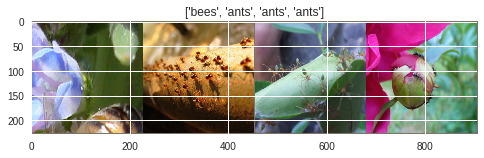

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
!pip uninstall -y Pillow

Uninstalling Pillow-5.4.1:
  Successfully uninstalled Pillow-5.4.1


In [9]:
!pip install Pillow==5.3.0

    100% |████████████████████████████████| 2.0MB 11.0MB/s 


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 27987942.14it/s]


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7244 Acc: 0.6598
val Loss: 0.2575 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4687 Acc: 0.8361
val Loss: 0.3605 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5528 Acc: 0.7705
val Loss: 0.4383 Acc: 0.8039

Epoch 3/24
----------
train Loss: 0.4044 Acc: 0.8402
val Loss: 0.3392 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4172 Acc: 0.8156
val Loss: 0.3358 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.7000 Acc: 0.7705
val Loss: 0.4484 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.5662 Acc: 0.7869
val Loss: 0.5541 Acc: 0.8105

Epoch 7/24
----------
train Loss: 0.4318 Acc: 0.8279
val Loss: 0.3467 Acc: 0.8562

Epoch 8/24
----------
train Loss: 0.3381 Acc: 0.8443
val Loss: 0.2977 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.3400 Acc: 0.8770
val Loss: 0.2769 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.2449 Acc: 0.9016
val Loss: 0.2876 Acc: 0.8758

Epoch 11/24
----------
train Loss: 0.2660 Acc: 0.8811
val Loss: 0.2663 Acc: 0.8824

Ep

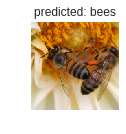

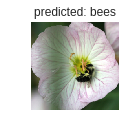

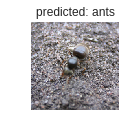

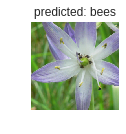

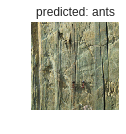

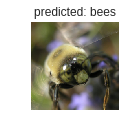

In [8]:
visualize_model(model_ft)